 >  <h1>Business case</h1>



----


Three data sets are provided for the project. 

* **Claim Data** (Dataset 1) – all claims that were found from a Loss History Report (LHR) at driver level (Only households with claims will appear in this dataset)

* **Predictor Dataset** (Dataset 2) – all information we have from this household’s insurance application (Application date of January 1, 2017)

* **Subsequent Loss Experience** (Dataset 3) – one year of subsequent loss-experience of these applicants (All information gathered after application date)

* Metadata – Names and descriptions of the variables contained in each of the datasets listed above.
----

***Objective:*** 

*Create a model where you are trying to identify if the applicant had a future loss (future_clm_ind) using the information known on or before the application date.*

---

*Use the above datasets to:*
1.	Aggregate Dataset 1 at the hhld_id to create the following claim count variables:
  * Number of At Fault claims in each of the last 5 years from application date
  * Number of Not At Fault claims in each of the last 5 years from application date
2.	Merge the Datasets 2 and 3, and the aggregated form of Dataset 1 using hhld_id
3.	Create a model where you are trying to identify if the applicant had a future loss (future_clm_ind) using the information known on or before the application date.


In [1]:
# NumPy for numerical computing
import numpy as np
# Pandas for DataFrames
import pandas as pd

In [2]:
import itertools
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter

In [3]:
# Installing Pandas Profiler for automated detailed Exploratory Data Analysis 
!pip install pandas-profiling --upgrade

     |████████████████████████████████| 256kB 6.6MB/s 
     |████████████████████████████████| 1.1MB 8.9MB/s 
     |████████████████████████████████| 3.1MB 20.0MB/s 
     |████████████████████████████████| 10.1MB 39.7MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 645kB 35.5MB/s 
     |████████████████████████████████| 112kB 45.3MB/s 
     |████████████████████████████████| 296kB 43.0MB/s 
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107413 sha256=d1d349dcbbdbe67f4ab1295b41982ea96207e8b0685c712d6f936263729d1b3b
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=fa60bbc966d4eedf444a93beff70bf2872a1c39c034d8b3f0a81a2ee01df814b
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db07554

In [4]:
from pandas_profiling import ProfileReport
# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

In [5]:
!pip install sweetviz --upgrade

     |████████████████████████████████| 15.1MB 282kB/s 


In [6]:
import sweetviz as sv


In [7]:
# for modeling purpose
!pip install scikit-learn 

In [8]:
from sklearn import preprocessing

In [9]:
import requests
import lxml.html as lh
from sklearn.cluster import KMeans
print("Libraries imported.")

Libraries imported.


> <h2> Loading Datset </h2>

* **Claim Data** (Dataset 1) – all claims that were found from a Loss History Report (LHR) at driver level (Only households with claims will appear in this dataset)

* **Predictor Dataset** (Dataset 2) – all information we have from this household’s insurance application (Application date of January 1, 2017)

* **Subsequent Loss Experience** (Dataset 3) – one year of subsequent loss-experience of these applicants (All information gathered after application date)

In [10]:
# Claim_Data.csv


df_data_1 = pd.read_csv('/content/Claim_Data.csv')
df_data_1.shape


(5000, 4)

In [11]:
# Predictor Dataset.csv


df_data_2 = pd.read_csv('/content/Predictor Dataset.csv')
df_data_2.shape


(20000, 41)

In [12]:
# Subsequent_Loss_Experience.csv


df_data_3 = pd.read_csv('/content/Subsequent_Loss_Experience.csv')
df_data_3.shape


(20000, 5)

In [13]:
df_data_1

,hhld_id,clm_dates,aft_ind,pd_amt
0,6599,12/9/2010,1,5736.39
1,1454,6/14/2010,1,3257.49
2,13691,1/8/2011,1,8190.45
3,10347,2/9/2014,0,428.48
4,6051,3/31/2010,0,107.57
...,...,...,...,...
4995,5567,6/2/2012,0,897.82
4996,3554,7/16/2011,1,6387.09
4997,12332,1/13/2014,0,534.27
4998,11310,7/11/2011,1,7709.68


In [14]:
df_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hhld_id    5000 non-null   int64  
 1   clm_dates  5000 non-null   object 
 2   aft_ind    5000 non-null   int64  
 3   pd_amt     5000 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 156.4+ KB


# **Data preperation steps:**
Step 1: 

  Aggregate Dataset 1 at the hhld_id to create the following claim count variables:

*	Number of At Fault claims in each of the last 5 years from application date
* Number of Not At Fault claims in each of the last 5 years from application date

In [15]:
ds_sort = df_data_1
# sort dataset by date
ds_sort["clm_dates"] = pd.to_datetime(ds_sort["clm_dates"])
ds_sort = ds_sort.sort_values(by="clm_dates")
ds_sort

,hhld_id,clm_dates,aft_ind,pd_amt
3934,3036,2010-01-01,0,270.99
737,13942,2010-01-01,0,337.38
352,14599,2010-01-01,0,169.53
470,7904,2010-01-01,0,240.98
766,10521,2010-01-02,0,293.41
...,...,...,...,...
665,4217,2017-03-27,1,0.00
2363,2839,2017-05-05,0,152.94
1096,6285,2017-08-24,0,196.01
4210,9722,2017-09-03,0,167.17


In [16]:
ds_sort['aft_ind'].value_counts()

0    3476
1    1524
Name: aft_ind, dtype: int64

#### The criteria to count a claim is that it must have at least one dollar paid out and be prior to the Application Date January 1, 2017.

In [17]:
#Apply filters to meet the criteria,so we get the start date from 1/1/2012 to 1/1/2017
ds1=df_data_1
ds1= ds1[(ds1["clm_dates"] > '2011-12-31') & (ds1['clm_dates']<= '2017-01-01')]

# Display the record
ds1

,hhld_id,clm_dates,aft_ind,pd_amt
3,10347,2014-02-09,0,428.48
6,2388,2016-08-01,1,2092.55
8,8845,2015-08-10,1,6133.88
11,14318,2015-11-26,0,157.36
12,13283,2012-04-28,0,164.90
...,...,...,...,...
4991,1621,2012-01-29,0,222.45
4993,10679,2012-06-04,1,10308.61
4995,5567,2012-06-02,0,897.82
4997,12332,2014-01-13,0,534.27


In [18]:
ds1['aft_ind'].value_counts()

0    2515
1    1087
Name: aft_ind, dtype: int64

#### Use the indicator to know if the claim is an At Fault loss or Not At Fault loss. 
 *Creating two cloumns fault_claims and not_at_fault_claims* 

In [19]:
df1_claim= ds1

In [20]:
df1_claim['fault_claims']=(df1_claim['aft_ind']==1).astype('int')
df1_claim['not_at_fault_claims']=(df1_claim['aft_ind']==0).astype('int')
df1_claim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,hhld_id,clm_dates,aft_ind,pd_amt,fault_claims,not_at_fault_claims
3,10347,2014-02-09,0,428.48,0,1
6,2388,2016-08-01,1,2092.55,1,0
8,8845,2015-08-10,1,6133.88,1,0
11,14318,2015-11-26,0,157.36,0,1
12,13283,2012-04-28,0,164.90,0,1
...,...,...,...,...,...,...
4991,1621,2012-01-29,0,222.45,0,1
4993,10679,2012-06-04,1,10308.61,1,0
4995,5567,2012-06-02,0,897.82,0,1
4997,12332,2014-01-13,0,534.27,0,1


In [21]:
# Display btm 10 rows of dataset_1 sored by ID
df1_claim.sort_values(by='hhld_id').tail(10)

,hhld_id,clm_dates,aft_ind,pd_amt,fault_claims,not_at_fault_claims
4844,19922,2015-01-17,0,234.20,0,1
4773,19922,2014-05-22,0,98.51,0,1
2949,19926,2016-12-03,0,171.92,0,1
2104,19929,2013-06-30,0,397.97,0,1
1858,19933,2016-09-22,0,199.15,0,1
4531,19960,2013-09-26,0,412.23,0,1
932,19980,2015-01-07,1,9711.55,1,0
2941,19991,2012-12-12,1,5715.19,1,0
3653,19994,2015-12-27,1,6506.34,1,0
1520,19997,2016-10-31,0,249.93,0,1


In [22]:
groupby_clm = df1_claim.groupby(['hhld_id'])['aft_ind'].value_counts(normalize=True)
groupby_clm

hhld_id  aft_ind
2        0          1.0
12       0          1.0
13       1          1.0
27       0          1.0
36       0          1.0
                   ... 
19960    0          1.0
19980    1          1.0
19991    1          1.0
19994    1          1.0
19997    0          1.0
Name: aft_ind, Length: 3408, dtype: float64

**Aggregate Dataset 1 at hhld_id**

In [23]:
# groupby hhld_id to count by col. 
claim =df1_claim.groupby(['hhld_id']).sum()
claim.reset_index(inplace=True)
claim.shape

(3279, 5)

In [24]:
claim.tail(15)

,hhld_id,aft_ind,pd_amt,fault_claims,not_at_fault_claims
3264,19901,1,9504.34,1,0
3265,19903,0,182.80,0,1
3266,19906,0,722.26,0,2
3267,19912,1,9793.59,1,0
3268,19917,0,131.60,0,1
3269,19919,0,356.49,0,1
3270,19922,0,332.71,0,2
3271,19926,0,171.92,0,1
3272,19929,0,397.97,0,1
3273,19933,0,199.15,0,1


In [25]:
claim.head(5)

,hhld_id,aft_ind,pd_amt,fault_claims,not_at_fault_claims
0,2,0,112.02,0,1
1,12,0,0.00,0,1
2,13,1,6499.32,1,0
3,27,0,233.49,0,1
4,36,0,236.18,0,1


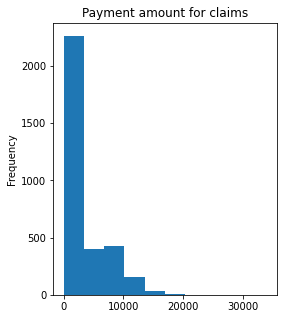

In [26]:
#Check range of payment ampout with histogram
claim['pd_amt'].plot(kind='hist',figsize=(4,5), title='Payment amount for claims')

In [27]:
#Drop 'aft_ind' and 'pd_amt'

to_drop = ['aft_ind' , 'pd_amt']
claim.drop(to_drop, inplace=True, axis=1)
claim.shape

(3279, 3)

In [28]:
#export to csv by giving meaningful name to the dataframe
claim.to_csv('Claim_Data1.csv')

In [ ]:
#from project_lib import Project

project = Project("State Farm Project","SF")
project.save_data(file_name = "Claim_aft_ind.csv",data = claim.to_csv(index=False))

In [29]:
final_ds1=pd.read_csv('Claim_Data1.csv', index_col='Unnamed: 0')
final_ds1.tail(2)

,hhld_id,fault_claims,not_at_fault_claims
3277,19994,1,0
3278,19997,0,1


In [30]:
final_ds1.shape

(3279, 3)

#### Step 2:

Merge the Datasets 2 and 3, and the aggregated form of Dataset 1 using hhld_id

In [31]:
df_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hhld_id          20000 non-null  int64  
 1   drvr_cnt         20000 non-null  int64  
 2   veh_cnt          20000 non-null  int64  
 3   min_age          20000 non-null  float64
 4   hoh_age          20000 non-null  float64
 5   max_age          20000 non-null  float64
 6   avg_age          20000 non-null  float64
 7   min_mon_lic      20000 non-null  float64
 8   hoh_mon_lic      20000 non-null  float64
 9   max_mon_lic      20000 non-null  float64
 10  avg_mon_lic      20000 non-null  float64
 11  cnt_yth          20000 non-null  int64  
 12  cnt_female       20000 non-null  int64  
 13  cnt_male         20000 non-null  int64  
 14  cnt_married      20000 non-null  int64  
 15  cnt_single       20000 non-null  int64  
 16  hoh_married      20000 non-null  bool   
 17  cnt_auto    

In [32]:
df_data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hhld_id         20000 non-null  int64  
 1   premium         20000 non-null  float64
 2   pd_amt          20000 non-null  float64
 3   loss_ratio      20000 non-null  float64
 4   future_clm_ind  20000 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 781.4 KB


#### Note: pmt_amt col already available in claim data set . Renameing it to match meta data

In [33]:
df_data_3 = df_data_3.rename(columns={'pd_amt':'loss_amount'})  # as per meta data loss amount for the one year 
df_data_3.head(2)

,hhld_id,premium,loss_amount,loss_ratio,future_clm_ind
0,15937,133.6,0.0,0.0,0
1,13778,145.8,0.0,0.0,0


In [34]:
# Merge the Datasets 2 and 3 using hhld_id
df_merge_2and3 = pd.merge(df_data_2,df_data_3,on='hhld_id',how='outer')

In [35]:
df_merge_2and3.shape

(20000, 45)

In [36]:
df_merge_2and3.head(2)

,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,curnt_insurer,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lien_cnt,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,premium,loss_amount,loss_ratio,future_clm_ind
0,15937,2,1,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,378.936926,0,2,0,1,1,True,1,0,0.0,0,0,0.0,0,PROGRESSIVE,3.0,1,25000.0,0,0,0.0,0,0,0,1,1,1,100,100,825.949106,35741,133.6,0.0,0.0,0
1,13778,1,1,35.644631,35.644631,35.644631,35.644631,235.735567,235.735567,235.735567,235.735567,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,1.5,1,25000.0,1,1,NaN,0,0,0,1,1,0,25,25,684.650216,87884,145.8,0.0,0.0,0


## Merge the Datasets 2 and 3, and the aggregated form of Dataset 1 using hhld_id

In [37]:
# df_merge_2and3: DataFrame with shape (20000, 45)
# final_ds1: DataFrame with shape (3279, 3){Aggregated Dataset 1}

combined_df = pd.merge(df_merge_2and3,final_ds1, on = 'hhld_id', how='outer')
combined_df.shape

(20000, 47)

In [38]:
combined_df.head(2)

,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,curnt_insurer,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lien_cnt,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,premium,loss_amount,loss_ratio,future_clm_ind,fault_claims,not_at_fault_claims
0,15937,2,1,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,378.936926,0,2,0,1,1,True,1,0,0.0,0,0,0.0,0,PROGRESSIVE,3.0,1,25000.0,0,0,0.0,0,0,0,1,1,1,100,100,825.949106,35741,133.6,0.0,0.0,0,1.0,1.0
1,13778,1,1,35.644631,35.644631,35.644631,35.644631,235.735567,235.735567,235.735567,235.735567,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,1.5,1,25000.0,1,1,NaN,0,0,0,1,1,0,25,25,684.650216,87884,145.8,0.0,0.0,0,NaN,NaN


In [39]:
# Replace missing aft indictor values with 0 for hhld_Id that never had a claim as 84% will have NaN . This is boolean indicator. 0: no claim in both cases.
combined_df[['fault_claims' , 'not_at_fault_claims']] = combined_df[['fault_claims' , 'not_at_fault_claims']].fillna(0)
combined_df

,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,curnt_insurer,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lien_cnt,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,premium,loss_amount,loss_ratio,future_clm_ind,fault_claims,not_at_fault_claims
0,15937,2,1,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,378.936926,0,2,0,1,1,True,1,0,0.0,0,0,0.0,0,PROGRESSIVE,3.0,1,25000.0,0,0,0.0,0,0,0,1,1,1,100,100,825.949106,35741,133.6,0.0,0.0,0,1.0,1.0
1,13778,1,1,35.644631,35.644631,35.644631,35.644631,235.735567,235.735567,235.735567,235.735567,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,1.5,1,25000.0,1,1,NaN,0,0,0,1,1,0,25,25,684.650216,87884,145.8,0.0,0.0,0,0.0,0.0
2,16063,1,1,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0,1,False,1,0,0.0,0,2,2.0,0,FARMERS,5.0,1,50000.0,0,1,NaN,0,0,0,1,1,1,100,100,596.318289,81525,167.0,0.0,0.0,0,0.0,0.0
3,12789,1,1,17.882127,17.882127,17.882127,17.882127,22.585530,22.585530,22.585530,22.585530,1,1,0,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,0.0,1,100000.0,1,0,NaN,0,0,1,1,1,1,100,100,636.757859,35741,150.3,0.0,0.0,0,0.0,0.0
4,5122,1,1,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,2.5,1,25000.0,0,0,NaN,0,0,0,0,1,1,50,50,669.569992,59792,117.0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,7971,1,1,22.317612,22.317612,22.317612,22.317612,75.811340,75.811340,75.811340,75.811340,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,MISSING,NaN,0,NaN,0,1,NaN,0,0,0,0,0,0,25,25,730.524944,52758,80.0,0.0,0.0,0,0.0,0.0
19996,5143,2,1,22.480599,50.319074,50.319074,36.399836,77.767185,411.828883,411.828883,244.798034,0,1,1,1,1,True,1,0,0.0,0,0,0.0,0,ALLSTATE,3.5,1,100000.0,0,1,NaN,0,0,0,0,0,0,50,50,733.680364,92002,80.0,0.0,0.0,0,0.0,0.0
19997,2554,2,2,42.579635,47.374177,47.374177,44.976906,318.955620,376.490121,376.490121,347.722870,0,0,2,2,0,True,2,0,0.0,0,1,0.5,0,PROGRESSIVE,5.0,1,50000.0,1,1,NaN,0,0,0,1,1,1,25,25,689.594122,77155,222.3,0.0,0.0,0,0.0,1.0
19998,6,1,1,46.832826,46.832826,46.832826,46.832826,369.993910,369.993910,369.993910,369.993910,0,1,0,0,1,False,1,0,0.0,0,0,0.0,0,MISSING,NaN,0,NaN,1,1,0.0,0,1,0,1,1,1,25,25,682.152567,87035,150.3,0.0,0.0,0,0.0,0.0


In [40]:
cols=list(combined_df.columns.values) # get the list of cols name to view and rearrage
cols

['hhld_id',
 'drvr_cnt',
 'veh_cnt',
 'min_age',
 'hoh_age',
 'max_age',
 'avg_age',
 'min_mon_lic',
 'hoh_mon_lic',
 'max_mon_lic',
 'avg_mon_lic',
 'cnt_yth',
 'cnt_female',
 'cnt_male',
 'cnt_married',
 'cnt_single',
 'hoh_married',
 'cnt_auto',
 'cnt_mtrcyc',
 'avg_majr_viol',
 'cnt_majr_viol',
 'cnt_minr_viol',
 'avg_minr_viol',
 'cnt_lic_susp',
 'curnt_insurer',
 'time_w_carr',
 'inforce_ind',
 'prior_bi',
 'fire_ind',
 'homeowner_ind',
 'veh_lien_cnt',
 'veh_lease_cnt',
 'veh_own_cnt',
 'monthly_pay_ind',
 'veh_w_coll_cnt',
 'veh_w_comp_cnt',
 'veh_w_ers_cnt',
 'curnt_bi_low',
 'curnt_bi_upp',
 'credit_score',
 'zipcode',
 'premium',
 'loss_amount',
 'loss_ratio',
 'future_clm_ind',
 'fault_claims',
 'not_at_fault_claims']

In [41]:
combined = combined_df.reindex(columns=['hhld_id', 'drvr_cnt', 'veh_cnt', 'min_age', 'hoh_age', 'max_age', 'avg_age', 'min_mon_lic', 'hoh_mon_lic', 'max_mon_lic', 'avg_mon_lic', 'cnt_yth',
 'cnt_female',
 'cnt_male',
 'cnt_married',
 'cnt_single',
 'hoh_married',
 'cnt_auto',
 'cnt_mtrcyc',
 'avg_majr_viol',
 'cnt_majr_viol',
 'cnt_minr_viol',
 'avg_minr_viol',
 'cnt_lic_susp',
 'curnt_insurer',
 'time_w_carr',
 'inforce_ind',
 'prior_bi',
 'fire_ind',
 'homeowner_ind',
 'veh_lien_cnt',
 'veh_lease_cnt',
 'veh_own_cnt',
 'monthly_pay_ind',
 'veh_w_coll_cnt',
 'veh_w_comp_cnt',
 'veh_w_ers_cnt',
 'curnt_bi_low',
 'curnt_bi_upp',
 'credit_score',
 'zipcode',
 'premium',
 'loss_amount',
 'loss_ratio',
 'fault_claims',
 'not_at_fault_claims','future_clm_ind'])

In [42]:
combined

,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,curnt_insurer,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lien_cnt,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,premium,loss_amount,loss_ratio,fault_claims,not_at_fault_claims,future_clm_ind
0,15937,2,1,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,378.936926,0,2,0,1,1,True,1,0,0.0,0,0,0.0,0,PROGRESSIVE,3.0,1,25000.0,0,0,0.0,0,0,0,1,1,1,100,100,825.949106,35741,133.6,0.0,0.0,1.0,1.0,0
1,13778,1,1,35.644631,35.644631,35.644631,35.644631,235.735567,235.735567,235.735567,235.735567,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,1.5,1,25000.0,1,1,NaN,0,0,0,1,1,0,25,25,684.650216,87884,145.8,0.0,0.0,0.0,0.0,0
2,16063,1,1,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0,1,False,1,0,0.0,0,2,2.0,0,FARMERS,5.0,1,50000.0,0,1,NaN,0,0,0,1,1,1,100,100,596.318289,81525,167.0,0.0,0.0,0.0,0.0,0
3,12789,1,1,17.882127,17.882127,17.882127,17.882127,22.585530,22.585530,22.585530,22.585530,1,1,0,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,0.0,1,100000.0,1,0,NaN,0,0,1,1,1,1,100,100,636.757859,35741,150.3,0.0,0.0,0.0,0.0,0
4,5122,1,1,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,2.5,1,25000.0,0,0,NaN,0,0,0,0,1,1,50,50,669.569992,59792,117.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,7971,1,1,22.317612,22.317612,22.317612,22.317612,75.811340,75.811340,75.811340,75.811340,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,MISSING,NaN,0,NaN,0,1,NaN,0,0,0,0,0,0,25,25,730.524944,52758,80.0,0.0,0.0,0.0,0.0,0
19996,5143,2,1,22.480599,50.319074,50.319074,36.399836,77.767185,411.828883,411.828883,244.798034,0,1,1,1,1,True,1,0,0.0,0,0,0.0,0,ALLSTATE,3.5,1,100000.0,0,1,NaN,0,0,0,0,0,0,50,50,733.680364,92002,80.0,0.0,0.0,0.0,0.0,0
19997,2554,2,2,42.579635,47.374177,47.374177,44.976906,318.955620,376.490121,376.490121,347.722870,0,0,2,2,0,True,2,0,0.0,0,1,0.5,0,PROGRESSIVE,5.0,1,50000.0,1,1,NaN,0,0,0,1,1,1,25,25,689.594122,77155,222.3,0.0,0.0,0.0,1.0,0
19998,6,1,1,46.832826,46.832826,46.832826,46.832826,369.993910,369.993910,369.993910,369.993910,0,1,0,0,1,False,1,0,0.0,0,0,0.0,0,MISSING,NaN,0,NaN,1,1,0.0,0,1,0,1,1,1,25,25,682.152567,87035,150.3,0.0,0.0,0.0,0.0,0


In [43]:
df_model=combined.round(3)
df_model.sort_values('hhld_id')

,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,curnt_insurer,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lien_cnt,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,premium,loss_amount,loss_ratio,fault_claims,not_at_fault_claims,future_clm_ind
10950,1,1,1,57.960,57.960,57.960,57.960,474.900,446.287,446.287,446.287,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,GEICO,0.5,1,100000.0,0,0,NaN,0,0,1,1,1,1,25,25,698.933,51365,167.00,0.000,0.000,0.0,0.0,0
5332,2,1,1,43.274,43.274,43.274,43.274,327.286,327.286,327.286,327.286,0,1,0,0,1,False,1,0,0.0,0,0,0.0,0,GEICO,0.0,1,25000.0,1,0,NaN,0,0,1,1,1,1,100,100,703.696,16107,120.24,0.000,0.000,0.0,1.0,0
13885,3,2,1,25.235,32.296,32.296,28.766,110.816,195.557,195.557,153.187,0,1,1,2,0,True,1,0,0.0,0,0,0.0,0,MISSING,NaN,0,NaN,1,1,NaN,0,1,1,1,1,1,25,25,804.472,68294,120.24,0.000,0.000,0.0,0.0,0
8022,4,1,1,58.391,58.391,58.391,58.391,508.698,508.698,508.698,508.698,0,0,1,1,0,True,1,0,0.0,0,0,0.0,0,GEICO,1.0,1,25000.0,0,0,NaN,0,0,0,1,1,1,25,25,648.401,45689,167.00,0.000,0.000,0.0,0.0,0
19010,5,2,1,40.654,53.830,53.830,47.242,295.852,453.966,453.966,374.909,0,0,2,2,0,True,1,0,0.0,0,0,0.0,0,OTHER,5.0,1,25000.0,1,1,NaN,0,1,1,1,1,1,25,25,697.085,36529,150.30,0.000,0.000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19847,19996,1,1,45.809,45.809,45.809,45.809,357.703,357.703,357.703,357.703,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,MISSING,NaN,0,NaN,0,0,NaN,0,0,1,1,1,1,50,50,616.729,74670,167.00,0.000,0.000,0.0,0.0,0
10984,19997,1,2,52.179,52.179,52.179,52.179,434.144,434.144,434.144,434.144,0,1,0,0,1,False,2,0,0.0,0,1,1.0,0,MISSING,NaN,0,NaN,0,0,NaN,0,0,0,2,2,2,250,250,740.122,96391,251.20,0.000,0.000,0.0,1.0,0
7772,19998,2,1,39.207,47.035,47.035,43.121,278.480,372.417,372.417,325.448,0,1,1,2,0,True,1,0,0.0,0,0,0.0,0,FARMERS,0.0,1,50000.0,0,1,NaN,0,0,0,0,0,0,25,25,780.247,52074,80.00,0.000,0.000,0.0,0.0,0
3131,19999,4,2,16.138,41.158,49.490,33.385,1.658,301.895,401.885,208.616,2,3,1,3,1,True,2,0,0.0,0,0,0.0,0,GEICO,5.0,1,25000.0,0,0,NaN,0,0,1,1,1,1,100,100,568.881,52611,247.00,805.084,3.259,0.0,0.0,1


In [44]:
# Export raw dataset that combines all 3 sets into one with 20k observations and 47 features
df_model.to_csv('Comdined dataset SF.csv')

In [45]:
c = pd.read_csv('Comdined dataset SF.csv',index_col='Unnamed: 0')

In [46]:
c.shape

(20000, 47)

In [47]:
c.head(2)

,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,curnt_insurer,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lien_cnt,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,premium,loss_amount,loss_ratio,fault_claims,not_at_fault_claims,future_clm_ind
0,15937,2,1,43.790,51.366,51.366,47.578,333.480,424.394,424.394,378.937,0,2,0,1,1,True,1,0,0.0,0,0,0.0,0,PROGRESSIVE,3.0,1,25000.0,0,0,0.0,0,0,0,1,1,1,100,100,825.949,35741,133.6,0.0,0.0,1.0,1.0,0
1,13778,1,1,35.645,35.645,35.645,35.645,235.736,235.736,235.736,235.736,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,1.5,1,25000.0,1,1,NaN,0,0,0,1,1,0,25,25,684.650,87884,145.8,0.0,0.0,0.0,0.0,0


> <h2> Feature Engineering</h2>

#### Data Cleaning

Step 1: Remove noise variables that has no impact on outcome.

In [48]:
Feature = c
Feature.drop(['hhld_id','zipcode'], axis=1, inplace=True)
Feature.shape

(20000, 45)

#### Quantitative Cleaning- check missing vlaues and either impute or remove 

In [49]:
Feature.isnull().sum()

drvr_cnt                   0
veh_cnt                    0
min_age                    0
hoh_age                    0
max_age                    0
avg_age                    0
min_mon_lic                0
hoh_mon_lic                0
max_mon_lic                0
avg_mon_lic                0
cnt_yth                    0
cnt_female                 0
cnt_male                   0
cnt_married                0
cnt_single                 0
hoh_married                0
cnt_auto                   0
cnt_mtrcyc                 0
avg_majr_viol              0
cnt_majr_viol              0
cnt_minr_viol              0
avg_minr_viol              0
cnt_lic_susp               0
curnt_insurer              0
time_w_carr             7010
inforce_ind                0
prior_bi                7010
fire_ind                   0
homeowner_ind              0
veh_lien_cnt           19974
veh_lease_cnt              0
veh_own_cnt                0
monthly_pay_ind            0
veh_w_coll_cnt             0
veh_w_comp_cnt


> **Missing Values**
---
* time_w_carr |---->    7010 (35.0%) missing values   
* prior_bi  |----->    7010 (35.0%) missing values 
* veh_lien_cnt |---->  19974 (99.9%) missing value 
* credit_score |----->  921 (4.6%) missing values
---

In [50]:
# Drop veh_lien_cnt  (99.9%) missing values
Feature.drop(['veh_lien_cnt'], axis=1, inplace=True)
Feature.shape

(20000, 44)

In [51]:
# credit_score has <5% missing value.Impute with mean.
# First, obtaining the mean of credit_score
cds_mean=Feature['credit_score'].mean() 
round(cds_mean,3)

663.646

In [52]:
# Second, replacing specific missing values with the above obtained Mean
Feature['credit_score'].fillna(cds_mean, inplace=True)
Feature.describe

<bound method NDFrame.describe of        drvr_cnt  veh_cnt  ...  not_at_fault_claims  future_clm_ind
0             2        1  ...                  1.0               0
1             1        1  ...                  0.0               0
2             1        1  ...                  0.0               0
3             1        1  ...                  0.0               0
4             1        1  ...                  0.0               0
...         ...      ...  ...                  ...             ...
19995         1        1  ...                  0.0               0
19996         2        1  ...                  0.0               0
19997         2        2  ...                  1.0               0
19998         1        1  ...                  0.0               0
19999         2        2  ...                  1.0               0

[20000 rows x 44 columns]>

In [53]:
# time_w_carr - Time with current insurer has 35% missing value. Impute with Median

Feature['time_w_carr'] = Feature['time_w_carr'].fillna(Feature['time_w_carr'].median())

In [54]:
# prior_bi -  Bodily Injury Coverage Individual Limit with current insurer  has 35% missing value. Impute with Median

Feature['prior_bi'] = Feature['prior_bi'].fillna(Feature['prior_bi'].median())

In [55]:
Feature.isna().sum() 

drvr_cnt               0
veh_cnt                0
min_age                0
hoh_age                0
max_age                0
avg_age                0
min_mon_lic            0
hoh_mon_lic            0
max_mon_lic            0
avg_mon_lic            0
cnt_yth                0
cnt_female             0
cnt_male               0
cnt_married            0
cnt_single             0
hoh_married            0
cnt_auto               0
cnt_mtrcyc             0
avg_majr_viol          0
cnt_majr_viol          0
cnt_minr_viol          0
avg_minr_viol          0
cnt_lic_susp           0
curnt_insurer          0
time_w_carr            0
inforce_ind            0
prior_bi               0
fire_ind               0
homeowner_ind          0
veh_lease_cnt          0
veh_own_cnt            0
monthly_pay_ind        0
veh_w_coll_cnt         0
veh_w_comp_cnt         0
veh_w_ers_cnt          0
curnt_bi_low           0
curnt_bi_upp           0
credit_score           0
premium                0
loss_amount            0


In [56]:
Feature

,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,curnt_insurer,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,premium,loss_amount,loss_ratio,fault_claims,not_at_fault_claims,future_clm_ind
0,2,1,43.790,51.366,51.366,47.578,333.480,424.394,424.394,378.937,0,2,0,1,1,True,1,0,0.0,0,0,0.0,0,PROGRESSIVE,3.0,1,25000.0,0,0,0,0,0,1,1,1,100,100,825.949,133.6,0.0,0.0,1.0,1.0,0
1,1,1,35.645,35.645,35.645,35.645,235.736,235.736,235.736,235.736,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,1.5,1,25000.0,1,1,0,0,0,1,1,0,25,25,684.650,145.8,0.0,0.0,0.0,0.0,0
2,1,1,16.000,16.000,16.000,16.000,0.000,0.000,0.000,0.000,1,1,0,0,1,False,1,0,0.0,0,2,2.0,0,FARMERS,5.0,1,50000.0,0,1,0,0,0,1,1,1,100,100,596.318,167.0,0.0,0.0,0.0,0.0,0
3,1,1,17.882,17.882,17.882,17.882,22.586,22.586,22.586,22.586,1,1,0,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,0.0,1,100000.0,1,0,0,0,1,1,1,1,100,100,636.758,150.3,0.0,0.0,0.0,0.0,0
4,1,1,16.000,16.000,16.000,16.000,0.000,0.000,0.000,0.000,1,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,2.5,1,25000.0,0,0,0,0,0,0,1,1,50,50,669.570,117.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1,1,22.318,22.318,22.318,22.318,75.811,75.811,75.811,75.811,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,MISSING,3.5,0,50000.0,0,1,0,0,0,0,0,0,25,25,730.525,80.0,0.0,0.0,0.0,0.0,0
19996,2,1,22.481,50.319,50.319,36.400,77.767,411.829,411.829,244.798,0,1,1,1,1,True,1,0,0.0,0,0,0.0,0,ALLSTATE,3.5,1,100000.0,0,1,0,0,0,0,0,0,50,50,733.680,80.0,0.0,0.0,0.0,0.0,0
19997,2,2,42.580,47.374,47.374,44.977,318.956,376.490,376.490,347.723,0,0,2,2,0,True,2,0,0.0,0,1,0.5,0,PROGRESSIVE,5.0,1,50000.0,1,1,0,0,0,1,1,1,25,25,689.594,222.3,0.0,0.0,0.0,1.0,0
19998,1,1,46.833,46.833,46.833,46.833,369.994,369.994,369.994,369.994,0,1,0,0,1,False,1,0,0.0,0,0,0.0,0,MISSING,3.5,0,50000.0,1,1,0,1,0,1,1,1,25,25,682.153,150.3,0.0,0.0,0.0,0.0,0


In [57]:
# Export Feature selected data with 20k observations and 44 features
Feature.to_csv('Featureed_DS_SF.csv')

In [58]:
f = pd.read_csv('Featureed_DS_SF.csv',index_col='Unnamed: 0')

In [59]:
f.head(2)

,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,curnt_insurer,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,premium,loss_amount,loss_ratio,fault_claims,not_at_fault_claims,future_clm_ind
0,2,1,43.790,51.366,51.366,47.578,333.480,424.394,424.394,378.937,0,2,0,1,1,True,1,0,0.0,0,0,0.0,0,PROGRESSIVE,3.0,1,25000.0,0,0,0,0,0,1,1,1,100,100,825.949,133.6,0.0,0.0,1.0,1.0,0
1,1,1,35.645,35.645,35.645,35.645,235.736,235.736,235.736,235.736,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,1.5,1,25000.0,1,1,0,0,0,1,1,0,25,25,684.650,145.8,0.0,0.0,0.0,0.0,0


In [60]:
col=list(f.columns.values) # get the list of cols name to view and rearrage
col

['drvr_cnt',
 'veh_cnt',
 'min_age',
 'hoh_age',
 'max_age',
 'avg_age',
 'min_mon_lic',
 'hoh_mon_lic',
 'max_mon_lic',
 'avg_mon_lic',
 'cnt_yth',
 'cnt_female',
 'cnt_male',
 'cnt_married',
 'cnt_single',
 'hoh_married',
 'cnt_auto',
 'cnt_mtrcyc',
 'avg_majr_viol',
 'cnt_majr_viol',
 'cnt_minr_viol',
 'avg_minr_viol',
 'cnt_lic_susp',
 'curnt_insurer',
 'time_w_carr',
 'inforce_ind',
 'prior_bi',
 'fire_ind',
 'homeowner_ind',
 'veh_lease_cnt',
 'veh_own_cnt',
 'monthly_pay_ind',
 'veh_w_coll_cnt',
 'veh_w_comp_cnt',
 'veh_w_ers_cnt',
 'curnt_bi_low',
 'curnt_bi_upp',
 'credit_score',
 'premium',
 'loss_amount',
 'loss_ratio',
 'fault_claims',
 'not_at_fault_claims',
 'future_clm_ind']

In [61]:
f[['drvr_cnt',
 'veh_cnt',
 'min_age',
 'hoh_age',
 'max_age',
 'avg_age',
 'min_mon_lic',
 'hoh_mon_lic',
 'max_mon_lic',
 'avg_mon_lic',
 'cnt_yth',
 'cnt_female',
 'cnt_male',
 'cnt_married',
 'cnt_single',
 'hoh_married',
 'cnt_auto',
 'cnt_mtrcyc',
 'avg_majr_viol',
 'cnt_majr_viol',
 'cnt_minr_viol',
 'avg_minr_viol',
 'cnt_lic_susp',
 'time_w_carr',
 'inforce_ind',
 'prior_bi',
 'fire_ind',
 'homeowner_ind',
 'veh_lease_cnt',
 'veh_own_cnt',
 'monthly_pay_ind',
 'veh_w_coll_cnt',
 'veh_w_comp_cnt',
 'veh_w_ers_cnt',
 'curnt_bi_low',
 'curnt_bi_upp',
 'credit_score',
 'premium',
 'loss_amount',
 'loss_ratio',
 'fault_claims',
 'not_at_fault_claims']].head()

,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,premium,loss_amount,loss_ratio,fault_claims,not_at_fault_claims
0,2,1,43.790,51.366,51.366,47.578,333.480,424.394,424.394,378.937,0,2,0,1,1,True,1,0,0.0,0,0,0.0,0,3.0,1,25000.0,0,0,0,0,0,1,1,1,100,100,825.949,133.6,0.0,0.0,1.0,1.0
1,1,1,35.645,35.645,35.645,35.645,235.736,235.736,235.736,235.736,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,1.5,1,25000.0,1,1,0,0,0,1,1,0,25,25,684.650,145.8,0.0,0.0,0.0,0.0
2,1,1,16.000,16.000,16.000,16.000,0.000,0.000,0.000,0.000,1,1,0,0,1,False,1,0,0.0,0,2,2.0,0,5.0,1,50000.0,0,1,0,0,0,1,1,1,100,100,596.318,167.0,0.0,0.0,0.0,0.0
3,1,1,17.882,17.882,17.882,17.882,22.586,22.586,22.586,22.586,1,1,0,0,1,False,1,0,0.0,0,0,0.0,0,0.0,1,100000.0,1,0,0,0,1,1,1,1,100,100,636.758,150.3,0.0,0.0,0.0,0.0
4,1,1,16.000,16.000,16.000,16.000,0.000,0.000,0.000,0.000,1,0,1,0,1,False,1,0,0.0,0,0,0.0,0,2.5,1,25000.0,0,0,0,0,0,0,1,1,50,50,669.570,117.0,0.0,0.0,0.0,0.0


In [62]:
Feature_Selected =f[['drvr_cnt',
 'veh_cnt',
 'min_age',
 'hoh_age',
 'max_age',
 'avg_age',
 'min_mon_lic',
 'hoh_mon_lic',
 'max_mon_lic',
 'avg_mon_lic',
 'cnt_yth',
 'cnt_female',
 'cnt_male',
 'cnt_married',
 'cnt_single',
 'cnt_auto',
 'cnt_mtrcyc',
 'avg_majr_viol',
 'cnt_majr_viol',
 'cnt_minr_viol',
 'avg_minr_viol',
 'cnt_lic_susp',
 'time_w_carr',
 'inforce_ind',
 'prior_bi',
 'fire_ind',
 'homeowner_ind',
 'veh_lease_cnt',
 'veh_own_cnt',
 'monthly_pay_ind',
 'veh_w_coll_cnt',
 'veh_w_comp_cnt',
 'veh_w_ers_cnt',
 'curnt_bi_low',
 'curnt_bi_upp',
 'credit_score',
 'premium',
 'loss_amount',
 'loss_ratio',
 'fault_claims',
 'not_at_fault_claims']]

In [63]:
Feature_Selected.head(5)

,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,premium,loss_amount,loss_ratio,fault_claims,not_at_fault_claims
0,2,1,43.790,51.366,51.366,47.578,333.480,424.394,424.394,378.937,0,2,0,1,1,1,0,0.0,0,0,0.0,0,3.0,1,25000.0,0,0,0,0,0,1,1,1,100,100,825.949,133.6,0.0,0.0,1.0,1.0
1,1,1,35.645,35.645,35.645,35.645,235.736,235.736,235.736,235.736,0,0,1,0,1,1,0,0.0,0,0,0.0,0,1.5,1,25000.0,1,1,0,0,0,1,1,0,25,25,684.650,145.8,0.0,0.0,0.0,0.0
2,1,1,16.000,16.000,16.000,16.000,0.000,0.000,0.000,0.000,1,1,0,0,1,1,0,0.0,0,2,2.0,0,5.0,1,50000.0,0,1,0,0,0,1,1,1,100,100,596.318,167.0,0.0,0.0,0.0,0.0
3,1,1,17.882,17.882,17.882,17.882,22.586,22.586,22.586,22.586,1,1,0,0,1,1,0,0.0,0,0,0.0,0,0.0,1,100000.0,1,0,0,0,1,1,1,1,100,100,636.758,150.3,0.0,0.0,0.0,0.0
4,1,1,16.000,16.000,16.000,16.000,0.000,0.000,0.000,0.000,1,0,1,0,1,1,0,0.0,0,0,0.0,0,2.5,1,25000.0,0,0,0,0,0,0,1,1,50,50,669.570,117.0,0.0,0.0,0.0,0.0


> **Create a model where you are trying to identify if the applicant had a future loss (future_clm_ind) using the information known on or before the application date.**

**Lets defind feature sets, X:**

In [64]:
X = Feature_Selected
X[0:5]

,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,premium,loss_amount,loss_ratio,fault_claims,not_at_fault_claims
0,2,1,43.790,51.366,51.366,47.578,333.480,424.394,424.394,378.937,0,2,0,1,1,1,0,0.0,0,0,0.0,0,3.0,1,25000.0,0,0,0,0,0,1,1,1,100,100,825.949,133.6,0.0,0.0,1.0,1.0
1,1,1,35.645,35.645,35.645,35.645,235.736,235.736,235.736,235.736,0,0,1,0,1,1,0,0.0,0,0,0.0,0,1.5,1,25000.0,1,1,0,0,0,1,1,0,25,25,684.650,145.8,0.0,0.0,0.0,0.0
2,1,1,16.000,16.000,16.000,16.000,0.000,0.000,0.000,0.000,1,1,0,0,1,1,0,0.0,0,2,2.0,0,5.0,1,50000.0,0,1,0,0,0,1,1,1,100,100,596.318,167.0,0.0,0.0,0.0,0.0
3,1,1,17.882,17.882,17.882,17.882,22.586,22.586,22.586,22.586,1,1,0,0,1,1,0,0.0,0,0,0.0,0,0.0,1,100000.0,1,0,0,0,1,1,1,1,100,100,636.758,150.3,0.0,0.0,0.0,0.0
4,1,1,16.000,16.000,16.000,16.000,0.000,0.000,0.000,0.000,1,0,1,0,1,1,0,0.0,0,0,0.0,0,2.5,1,25000.0,0,0,0,0,0,0,1,1,50,50,669.570,117.0,0.0,0.0,0.0,0.0


**Lets defind feature sets, Y:**

In [65]:
y = f['future_clm_ind'].values
y[0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

# Classification

Now, use the training set to build an accurate model. Then use the test set to report the accuracy of the model going to use the following algorithm:

* K Nearest Neighbor(KNN) 
* Decision Tree 
* Support Vector Machine 
* Logistic Regression 

Notice:
You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.Using  either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms. 

## K Nearest Neighbor(KNN)
Find the best k to build the model with the best accuracy.To find the best k, split Featureed_DS_SF.csv into train and test to find the best k.

In [66]:
#Splitting dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split( X,y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape,y_test.shape)

Train set: (16000, 41) (16000,)
Test set: (4000, 41) (4000,)


[1.      0.99975 0.99975 0.99975 0.99975 0.99975 0.99975 0.99975 0.99975]


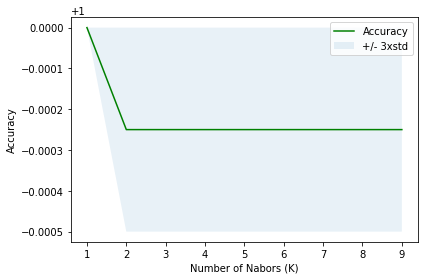

The best Acuuracy was with 1.0 with k= 1


In [67]:
#import library
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    #Train
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test,yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

#accuracy
print(mean_acc)

#plot model accuracy for Differnt number of Neighbors
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc -1 * std_acc,mean_acc + 1 * std_acc,alpha=0.10)
plt.legend(('Accuracy', '+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

#result
print("The best Acuuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

## Decision Tree

In [68]:
from sklearn.tree import DecisionTreeClassifier

In [69]:
Future_Claim = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
Future_Claim

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [70]:
#Training
Future_Claim.fit(X_train,y_train)
Future_Claim

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Support Vector machine

In [71]:
#import library
from sklearn import svm

In [72]:
#training
clf = svm.SVC()

In [73]:
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


## Logistic Regression

In [74]:
#import library
from sklearn.linear_model import LogisticRegression

In [75]:
#training
LR = LogisticRegression(C=0.01).fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [76]:
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Model Evaluating using Test set

In [77]:
#import lib
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

Going to Load Test set for Evaluation "Featureed_DS_SF.csv"

In [78]:
test_df = pd.read_csv('Featureed_DS_SF.csv',index_col='Unnamed: 0' )
test_df.head()

,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,curnt_insurer,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,premium,loss_amount,loss_ratio,fault_claims,not_at_fault_claims,future_clm_ind
0,2,1,43.790,51.366,51.366,47.578,333.480,424.394,424.394,378.937,0,2,0,1,1,True,1,0,0.0,0,0,0.0,0,PROGRESSIVE,3.0,1,25000.0,0,0,0,0,0,1,1,1,100,100,825.949,133.6,0.0,0.0,1.0,1.0,0
1,1,1,35.645,35.645,35.645,35.645,235.736,235.736,235.736,235.736,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,1.5,1,25000.0,1,1,0,0,0,1,1,0,25,25,684.650,145.8,0.0,0.0,0.0,0.0,0
2,1,1,16.000,16.000,16.000,16.000,0.000,0.000,0.000,0.000,1,1,0,0,1,False,1,0,0.0,0,2,2.0,0,FARMERS,5.0,1,50000.0,0,1,0,0,0,1,1,1,100,100,596.318,167.0,0.0,0.0,0.0,0.0,0
3,1,1,17.882,17.882,17.882,17.882,22.586,22.586,22.586,22.586,1,1,0,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,0.0,1,100000.0,1,0,0,0,1,1,1,1,100,100,636.758,150.3,0.0,0.0,0.0,0.0,0
4,1,1,16.000,16.000,16.000,16.000,0.000,0.000,0.000,0.000,1,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,2.5,1,25000.0,0,0,0,0,0,0,1,1,50,50,669.570,117.0,0.0,0.0,0.0,0.0,0


In [79]:
test_df.shape

(20000, 44)

In [80]:
#Pre-processing 

Feature_test = test_df[['drvr_cnt',
 'veh_cnt',
 'min_age',
 'hoh_age',
 'max_age',
 'avg_age',
 'min_mon_lic',
 'hoh_mon_lic',
 'max_mon_lic',
 'avg_mon_lic',
 'cnt_yth',
 'cnt_female',
 'cnt_male',
 'cnt_married',
 'cnt_single',
 'cnt_auto',
 'cnt_mtrcyc',
 'avg_majr_viol',
 'cnt_majr_viol',
 'cnt_minr_viol',
 'avg_minr_viol',
 'cnt_lic_susp',
 'time_w_carr',
 'inforce_ind',
 'prior_bi',
 'fire_ind',
 'homeowner_ind',
 'veh_lease_cnt',
 'veh_own_cnt',
 'monthly_pay_ind',
 'veh_w_coll_cnt',
 'veh_w_comp_cnt',
 'veh_w_ers_cnt',
 'curnt_bi_low',
 'curnt_bi_upp',
 'credit_score',
 'premium',
 'loss_amount',
 'loss_ratio',
 'fault_claims',
 'not_at_fault_claims']]

In [81]:
test_X = Feature_test

test_X = preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]

array([[ 0.65711585, -0.56410297,  0.33290267,  0.19437986,  0.15322638,
         0.23417972,  0.34389136,  0.20900088,  0.16797996,  0.2533645 ,
        -0.28848722,  1.72107202, -1.08032925,  0.27973561,  0.35075302,
        -0.49210778, -0.17083614, -0.09894598, -0.10569424, -0.44356387,
        -0.41834871, -0.10431655, -0.19037336,  0.73460594, -0.78781543,
        -0.81454179, -0.91897115, -0.19997503, -0.72698865, -0.65691457,
         0.19688043,  0.19567519,  0.32108777,  0.59704045,  0.59704045,
         1.63894716, -0.46808085, -0.19973295, -0.18889542,  4.07713528,
         2.44611793],
       [-0.75179463, -0.56410297, -0.22858985, -0.85597123, -0.88768641,
        -0.68328355, -0.21793964, -0.83506304, -0.86617287, -0.66107886,
        -0.28848722, -1.07628194,  0.33352921, -0.85142335,  0.35075302,
        -0.49210778, -0.17083614, -0.09894598, -0.10569424, -0.44356387,
        -0.41834871, -0.10431655, -1.19128485,  0.73460594, -0.78781543,
         1.22768409,  1.08817

In [82]:
#Pre-processing loan_test
test_y = test_df['future_clm_ind'].values
test_y[0:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0])

In [83]:
#predicted y
yhat_knn = neigh.predict(test_X)

#jaccard
jaccard_knn = jaccard_score(test_y,yhat_knn,pos_label = 1)
print("KNN Jaccard index:", jaccard_knn)

#f1_score
f1_score_knn = f1_score(test_y,yhat_knn, average='weighted')
print("KNN F1-score:", f1_score_knn)

KNN Jaccard index: 0.0
KNN F1-score: 0.9353074570033989


In [84]:

#Decision Tree
#Predicted y
yhat_dt = Future_Claim.predict(test_X)

#jaccard
jaccard_dt = jaccard_score(test_y,yhat_dt, pos_label = 1)
print("DT JAccard index:", jaccard_dt)

#f1_score
f1_score_dt = f1_score(test_y,yhat_dt, average='weighted')
print("DT F1-score:", f1_score_dt)

DT JAccard index: 0.998849252013809
DT F1-score: 0.9999499862607417


In [85]:
#Support Vector machine
#predicted y
yhat_svm = clf.predict(test_X)

#jaccard
jaccard_svm = jaccard_score(test_y, yhat_svm,pos_label = 1)
print("SVM Jaccard index:", jaccard_svm)

#f1-score
f1_score_svm = f1_score(test_y, yhat_svm, average='weighted')
print("SVM F1-score:", f1_score_svm)

SVM Jaccard index: 0.0
SVM F1-score: 0.9353074570033989


In [86]:
#Logistic Regression'
#predicted y
yhat_lg = LR.predict(test_X)
yhat_lg_prob = LR.predict_proba(test_X)

#jaccard
jaccard_lg = jaccard_score(test_y, yhat_lg, pos_label = 1)
print("LR jaccard index:", jaccard_lg)

#f1-score
f1_score_lg = f1_score(test_y, yhat_lg, average='weighted')
print("LR F1-score:", f1_score_lg)

#logloss
logloss_lg = log_loss(test_y, yhat_lg_prob)
print("LR log loss:", logloss_lg)

LR jaccard index: 0.12667638483965016
LR F1-score: 0.788740274888688
LR log loss: 0.6796562888866838


In [87]:
js_list = (jaccard_knn,jaccard_dt,jaccard_svm,jaccard_lg)
f1_list = (f1_score_knn,f1_score_dt,f1_score_svm,f1_score_lg)
l1_list = ('NA','NA','NA',logloss_lg)

In [88]:

columns = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
index = ['Jaccard', 'F1-score', 'Logloss']

In [89]:
accuracy_df =pd.DataFrame([js_list,f1_list,l1_list], index = index, columns = columns)


> # Report 1

In [90]:
accuracy_df1 = accuracy_df.transpose()
accuracy_df1.columns.name = 'Algorithm'
accuracy_df1

Algorithm,Jaccard,F1-score,Logloss
KNN,0,0.935307,NA
Decision Tree,0.998849,0.99995,NA
SVM,0,0.935307,NA
Logistic Regression,0.126676,0.78874,0.679656


In [91]:
Feature_test2=test_df[['fault_claims', 'not_at_fault_claims']]
test_X1 = Feature_test

test_X1 = preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X1[0:5]

array([[ 0.65711585, -0.56410297,  0.33290267,  0.19437986,  0.15322638,
         0.23417972,  0.34389136,  0.20900088,  0.16797996,  0.2533645 ,
        -0.28848722,  1.72107202, -1.08032925,  0.27973561,  0.35075302,
        -0.49210778, -0.17083614, -0.09894598, -0.10569424, -0.44356387,
        -0.41834871, -0.10431655, -0.19037336,  0.73460594, -0.78781543,
        -0.81454179, -0.91897115, -0.19997503, -0.72698865, -0.65691457,
         0.19688043,  0.19567519,  0.32108777,  0.59704045,  0.59704045,
         1.63894716, -0.46808085, -0.19973295, -0.18889542,  4.07713528,
         2.44611793],
       [-0.75179463, -0.56410297, -0.22858985, -0.85597123, -0.88768641,
        -0.68328355, -0.21793964, -0.83506304, -0.86617287, -0.66107886,
        -0.28848722, -1.07628194,  0.33352921, -0.85142335,  0.35075302,
        -0.49210778, -0.17083614, -0.09894598, -0.10569424, -0.44356387,
        -0.41834871, -0.10431655, -1.19128485,  0.73460594, -0.78781543,
         1.22768409,  1.08817

In [92]:
#Pre-processing Future Claim
test_y = test_df['future_clm_ind'].values
test_y[0:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0])

In [94]:
#predicted y
yhat_knn2 = neigh.predict(test_X1)

#jaccard
jaccard_knn2 = jaccard_score(test_y,yhat_knn,pos_label = 1)
print("KNN Jaccard index:", jaccard_knn2)

#f1_score
f1_score_knn2 = f1_score(test_y,yhat_knn, average='weighted')
print("KNN F1-score:", f1_score_knn2)

KNN Jaccard index: 0.0
KNN F1-score: 0.9353074570033989


In [95]:
#Decision Tree
#Predicted y
yhat_dt2 = Future_Claim.predict(test_X1)

#jaccard
jaccard_dt2 = jaccard_score(test_y,yhat_dt, pos_label = 1)
print("DT JAccard index:", jaccard_dt2)

#f1_score
f1_score_dt2 = f1_score(test_y,yhat_dt, average='weighted')
print("DT F1-score:", f1_score_dt2)

DT JAccard index: 0.998849252013809
DT F1-score: 0.9999499862607417


In [96]:

#Support Vector machine
#predicted y
yhat_svm2 = clf.predict(test_X1)

#jaccard
jaccard_svm2 = jaccard_score(test_y, yhat_svm,pos_label = 1)
print("SVM Jaccard index:", jaccard_svm2)

#f1-score
f1_score_svm2 = f1_score(test_y, yhat_svm, average='weighted')
print("SVM F1-score:", f1_score_svm2)

SVM Jaccard index: 0.0
SVM F1-score: 0.9353074570033989


In [97]:
#Logistic Regression'
#predicted y
yhat_lg2 = LR.predict(test_X1)
yhat_lg_prob2 = LR.predict_proba(test_X)

#jaccard
jaccard_lg2 = jaccard_score(test_y, yhat_lg2, pos_label = 1)
print("LR jaccard index:", jaccard_lg2)

#f1-score
f1_score_lg2 = f1_score(test_y, yhat_lg2, average='weighted')
print("LR F1-score:", f1_score_lg2)

#logloss
logloss_lg2 = log_loss(test_y, yhat_lg_prob2)
print("LR log loss:", logloss_lg2)

LR jaccard index: 0.12667638483965016
LR F1-score: 0.788740274888688
LR log loss: 0.6796562888866838


In [98]:
js_list = (jaccard_knn2,jaccard_dt2,jaccard_svm2,jaccard_lg2)
f1_list = (f1_score_knn2,f1_score_dt2,f1_score_svm2,f1_score_lg2)
l1_list = ('NA','NA','NA',logloss_lg2)

In [99]:
columns = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
index = ['Jaccard', 'F1-score', 'Logloss']

In [101]:
accuracy_df2 =pd.DataFrame([js_list,f1_list,l1_list], index = index, columns = columns)

## Report 2


In [102]:

accuracy_df3 = accuracy_df.transpose()
accuracy_df3.columns.name = 'Algorithm'
accuracy_df3

Algorithm,Jaccard,F1-score,Logloss
KNN,0,0.935307,NA
Decision Tree,0.998849,0.99995,NA
SVM,0,0.935307,NA
Logistic Regression,0.126676,0.78874,0.679656
